# PUI2016 HW6 - jp4772
## Assignment 1

In [262]:
import geopandas as gp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

import os
import json
import zipfile

plt.style.use('ggplot')

if os.getenv("PUIDATA"):
    data_path = os.getenv("PUIDATA")
else:
    os.system('mkdir data')
    data_path = "./data"
    
%matplotlib inline

In [136]:
# Download energy usage data
energy_csv = data_path + "/energy.csv"

os.system("curl -o " + energy_csv + " https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD")

energy = pd.read_csv(energy_csv)

In [137]:
# Download and unzip MapPLUTO data
pluto_file = data_path + "/pluto.zip"

os.system("curl -o " + pluto_file + " https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")
pluto_zip = zipfile.ZipFile(pluto_file)
pluto_zip.extractall(data_path + '/pluto')

bsize = gp.read_file(data_path + '/pluto/MNMapPLUTO.shp')

## Clean Energy Data

In [138]:
# Save only the BBL, EUI, and square footage columns
energy = energy.loc[:, ["NYC Borough, Block, and Lot (BBL)", "Site EUI(kBtu/ft2)", "Reported Property Floor Area (Building(s)) (ft²)"]]

In [139]:
# Rename the columns
energy.columns = ["bbl", "eui_ft2", "prop_ft2"]
energy.head()

,bbl,eui_ft2,prop_ft2
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [140]:
# Convert the eui and ft2 columns into floats
energy.eui_ft2 = pd.to_numeric(energy.eui_ft2, errors='coerce')
energy.prop_ft2 = pd.to_numeric(energy.prop_ft2, errors='coerce')

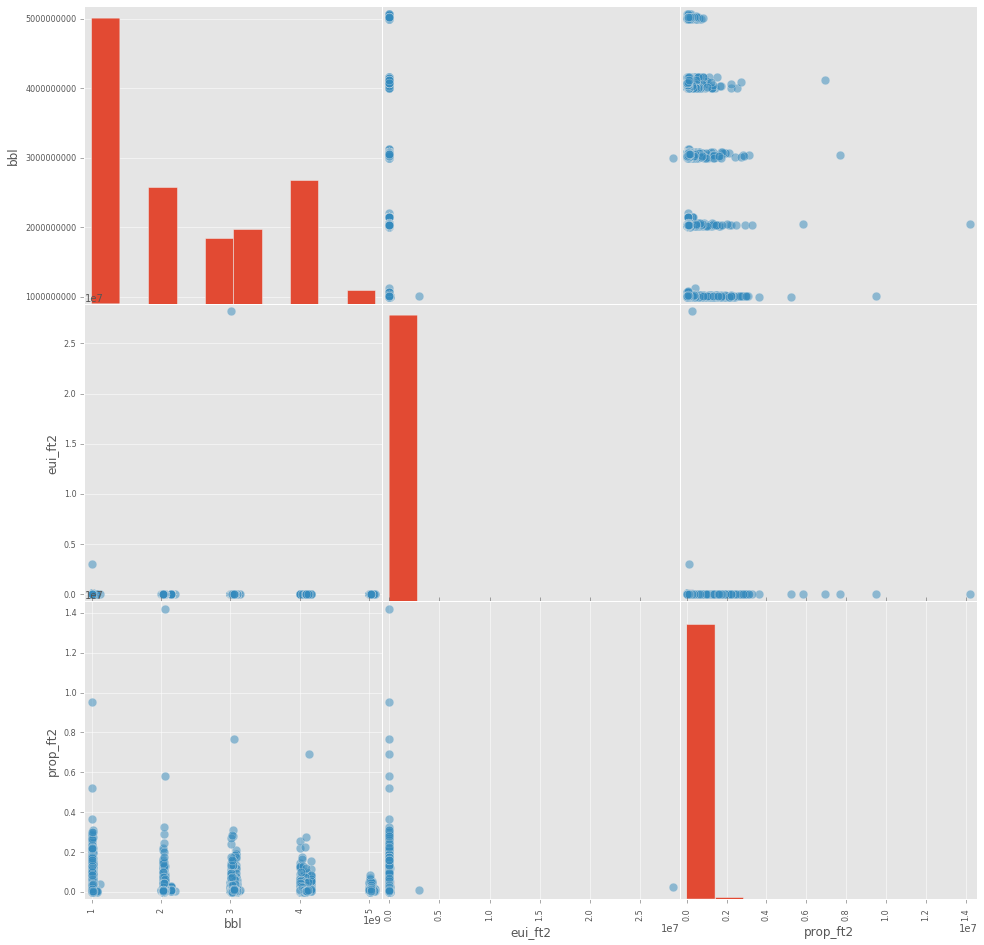

In [141]:
tmp = scatter_matrix(energy, s=300, figsize=(16, 16))

### Figure 1: Scatter matrix of bbl, energy consumption, and property square feet

## Merge Datasets

In [142]:
# Only use the bbl, units residents and units total columns
bsize = bsize.loc[:, ["BBL", "UnitsRes", "UnitsTotal"]]
bsize.columns = ["bbl", "units_res", "units_total"]

In [187]:
energy_size = pd.merge(energy, bsize, on="bbl")

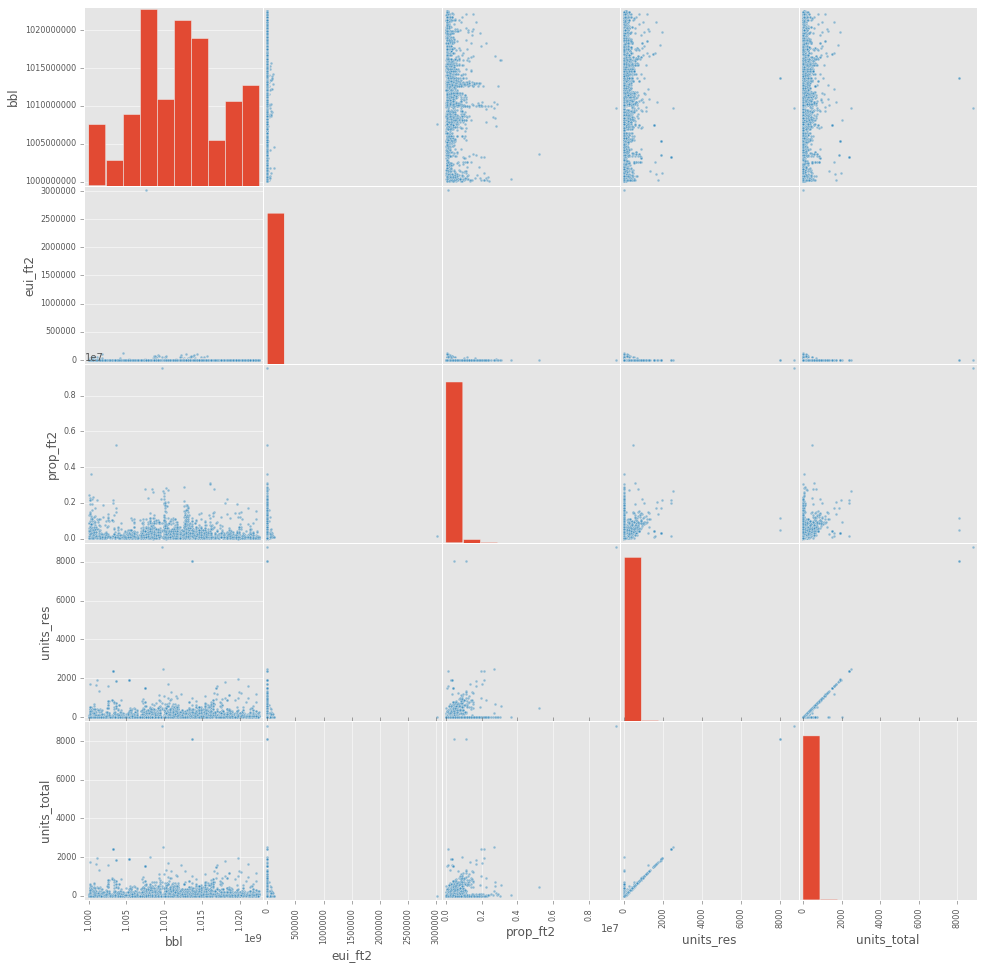

In [144]:
tmp = scatter_matrix (energy_size, s=30, figsize=(16, 16))

### Figure 2: Scatter matrix of building bbl, energy consumption, building sq feet, building residential units and building total units

In [145]:
energy_size.head()

,bbl,eui_ft2,prop_ft2,units_res,units_total
0,1.006700e+09,NaN,NaN,0,1
1,1.004370e+09,NaN,NaN,0,4
2,1.013110e+09,125.4,330000.0,0,56
3,1.009220e+09,NaN,NaN,148,148
4,1.007400e+09,NaN,68329.0,0,1


In [188]:
# Find total energy usage by multiplying the square footage with the energy use per sq. foot
energy_size['total_energy'] = energy_size.eui_ft2 * energy_size.prop_ft2

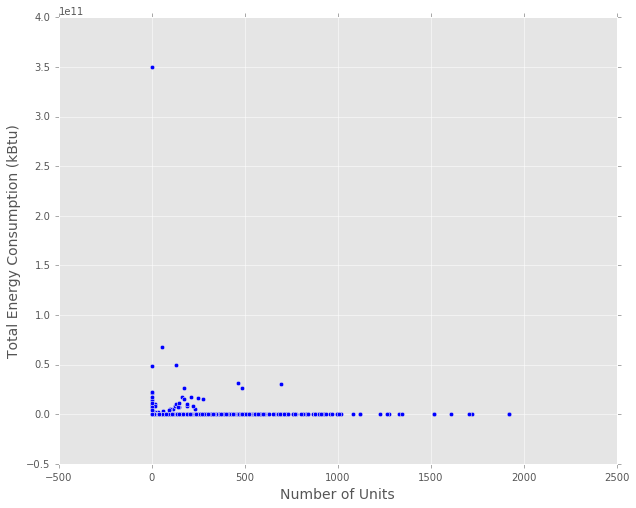

In [201]:
# Plot without axis limits
f, ax = plt.subplots(figsize=(10, 8))

ax.scatter(energy_size.units_total, energy_size.total_energy)

ax.set_ylabel("Total Energy Consumption (kBtu)", fontsize=14)
ax.set_xlabel("Number of Units", fontsize=14)

### Figure 3: Scatter plot of number of total units to total energy consumption (unzoomed)

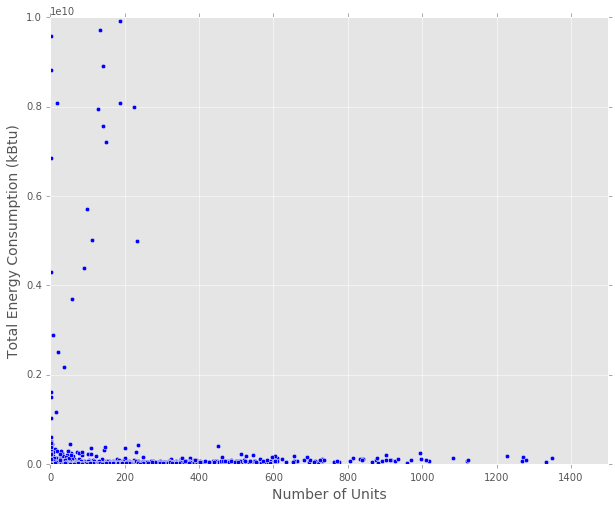

In [204]:
# Plot with axis limits
f, ax = plt.subplots(figsize=(10, 8))

ax.set_xlim([0,1500])
ax.set_ylim([0,0.1e11])

ax.set_xlabel("Number of Units", fontsize=14)
ax.set_ylabel("Total Energy Consumption (kBtu)", fontsize=14)

ax.scatter(energy_size.units_total, energy_size.total_energy)

### Figure 4: Scatter plot of number of total units to total energy consumption (zoomed)

## Log Plot

In [194]:
# Clean up outliers including buildings with 0 units and 0 energy
energy_size = energy_size[energy_size.units_total != 0]
energy_size = energy_size[energy_size.units_total < 2000]
energy_size = energy_size[energy_size.total_energy != 0]

In [196]:
# Drop nas
energy_size.dropna(inplace=True)

In [195]:
# Looks like we still have a good data set!
len(energy_size)

4990

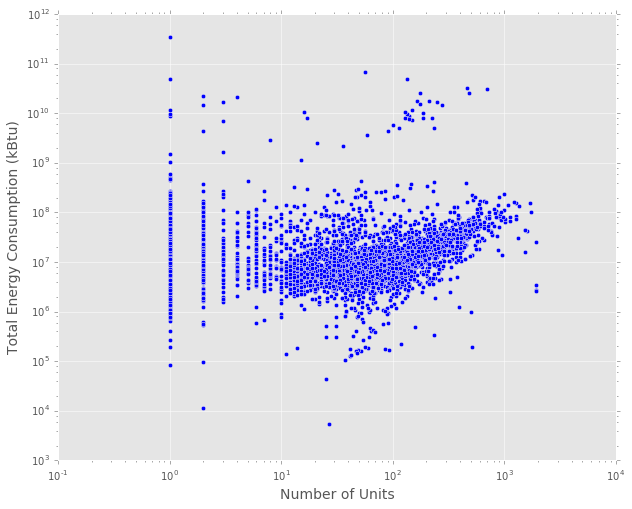

In [263]:
# Plot logged data (using matplotlib's log scale)
f, ax = plt.subplots(figsize=(10, 8))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel("Total Energy Consumption (kBtu)", fontsize=14)
ax.set_xlabel("Number of Units", fontsize=14)

ax.scatter(energy_size.units_total, energy_size.total_energy)

### Figure 5: Scatter plot of logged number of units to logged total energy consumption

## Fit a Line

In [266]:
# Save logged columns for later us
dfLog = pd.DataFrame(data={
        "units": np.log(energy_size.units_total),
        "energy": np.log(energy_size.total_energy)
    })

logUnits = np.log(energy_size.units_total)
logEnergy = np.log(energy_size.total_energy)

### 1. Fit a line to Units vs Energy

In [224]:
# Get the fitted line
line1 = np.poly1d(np.polyfit(logUnits, logEnergy, 1))

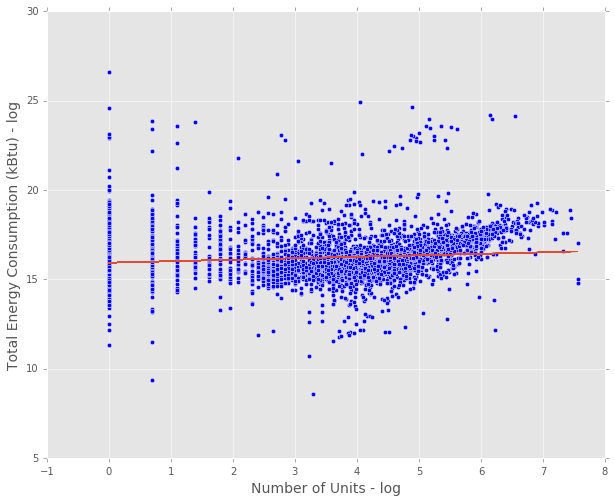

In [254]:
f, ax = plt.subplots(figsize=(10, 8))

ax.set_ylabel("Total Energy Consumption (kBtu) - log", fontsize=14)
ax.set_xlabel("Number of Units - log", fontsize=14)

ax.plot(logUnits, line1(logUnits), '-', label="Best fit")
ax.scatter(logUnits, logEnergy)

### Figure 6: Scatter plot of logged number of units to logged total energy consumption with fitted line

### 2. Fit a line to Energy vs Units

In [226]:
# Get the fitted line
line2 = np.poly1d(np.polyfit(logEnergy, logUnits, 1))

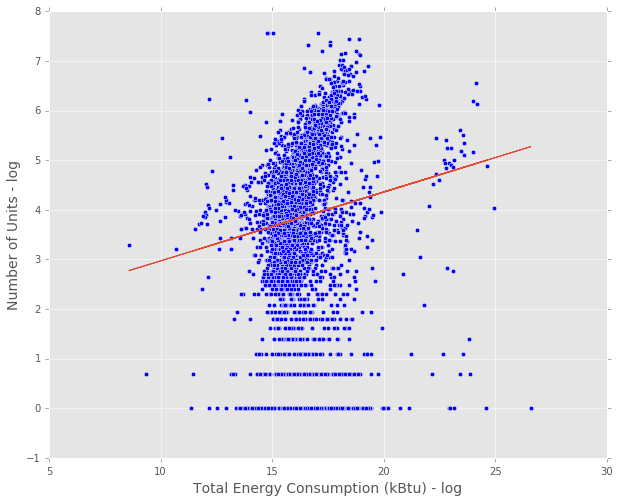

In [255]:
f, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel("Total Energy Consumption (kBtu) - log", fontsize=14)
ax.set_ylabel("Number of Units - log", fontsize=14)

ax.plot(logEnergy, line2(logEnergy), '-', label="Best fit")
ax.scatter(logEnergy, logUnits)

### Figure 7: Scatter plot of logged total energy consumption to logged number of units with fitted line

### 3. Evaluate which is better by calculating the chi square

In [ ]:
def chisq(X, Y, model_params):
    """
    
    """
    model = model_params[0] + (model_params[1] * X)
    num = (model - Y).map(np.square)
    denom = Y
    return (num / denom).sum()

### 4. Fit a 2nd-degree polynomial to the Units vs Energy

In [237]:
# 4. Fit a 2nd degree polynomial to the Units vs Energy
line4 = np.poly1d(np.polyfit(logUnits, logEnergy, 2))

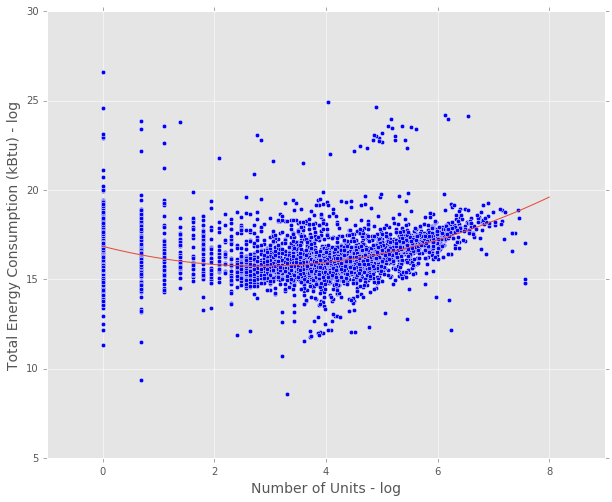

In [256]:
f, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 8, 100)

ax.set_ylabel("Total Energy Consumption (kBtu) - log", fontsize=14)
ax.set_xlabel("Number of Units - log", fontsize=14)

ax.plot(x, line4(x), '-', label="Best fit")
ax.scatter(logUnits, logEnergy)

### Figure 8: Scatter plot of logged number of units to logged total energy consumption with fitted line

### 5. Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test

In [330]:
# Check 
ols = smf.ols('energy ~ units', data=dfLog).fit()
ols2 = smf.ols('energy ~ units + I(units**2)', data=dfLog).fit()

LR = -2 * (ols.llf - ols2.llf)

print("LR Stat: ", LR)

LR Stat:  764.412405862


In [297]:
# Check to see if my LR stat was correct
ols2.compare_lr_test(ols)

(764.41240586239837, 2.9489337813795985e-168, 1.0)

In [325]:
# Print both summaries
print(ols.summary())
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     58.05
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           3.04e-14
Time:                        16:13:39   Log-Likelihood:                -8016.8
No. Observations:                4990   AIC:                         1.604e+04
Df Residuals:                    4988   BIC:                         1.605e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.9265      0.045    353.307      0.0

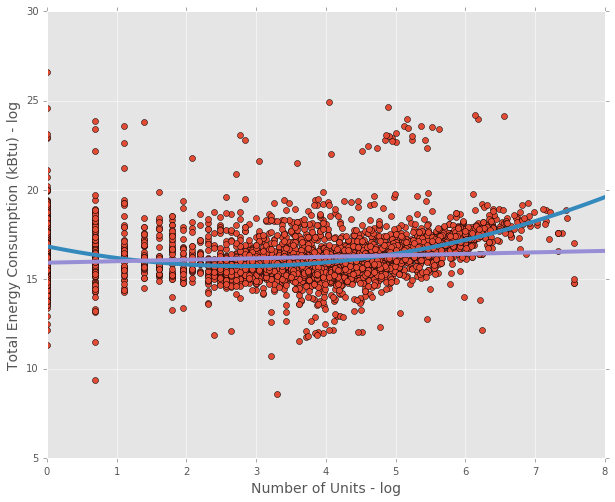

In [326]:
# Plot both models
f, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 8, 100)

ax.set_ylabel("Total Energy Consumption (kBtu) - log", fontsize=14)
ax.set_xlabel("Number of Units - log", fontsize=14)

ax.plot(logUnits, logEnergy, "o")
ax.plot(x, line4(x), '-', linewidth=4, label="2nd Degree")
ax.plot(x, line1(x), '-', linewidth=4, label="1st Degree")

### Figure 8: Scatter plot of logged number of units to logged total energy consumption with 1st and 2nd degree polynomial fitted lines.